## Social networks and recommender systems: 
### Graph machine learning

In [1]:
import platform

print(platform.platform())

import sys

print(sys.executable)
print(sys.version)
print("Hello, from this cell")


macOS-10.16-x86_64-i386-64bit
/Users/musa.official/opt/anaconda3/bin/python
3.9.13 (main, Aug 25 2022, 18:29:29) 
[Clang 12.0.0 ]
Hello, from this cell


In [17]:
%pip install --upgrade charset_normalizer
%pip install gensim==3.4.0
%pip install smart_open==1.9.0

  Using cached charset_normalizer-3.3.2-cp38-cp38-macosx_11_0_arm64.whl.metadata (33 kB)
Using cached charset_normalizer-3.3.2-cp38-cp38-macosx_11_0_arm64.whl (119 kB)
  Attempting uninstall: charset_normalizer
    Found existing installation: charset-normalizer 2.0.4
    Uninstalling charset-normalizer-2.0.4:
      Successfully uninstalled charset-normalizer-2.0.4


In [208]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import smart_open
from gensim.models import Word2Vec
from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer



In [209]:
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [210]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [211]:
# Filter ratings based on the minimum threshold
min_threshold = 4
filtered_ratings = ratings[ratings['rating'] >= min_threshold]

# Define the source, target, and edge type columns
source_column = 'userId'
target_column = 'movieId'
edge_type_column = 'rating'

# Construct the graph
graph = StellarGraph(edges=filtered_ratings, source_column=source_column, target_column=target_column, edge_type_column=edge_type_column)

In [212]:
# Define the minimum weight threshold
min_weight_threshold = 60

# Convert the StellarGraph to a NetworkX graph
nx_graph = graph.to_networkx()

# Create edges based on the pointwise mutual information
edges = []

# Iterate over pairs of nodes
for movie1, movie2 in combinations(nx_graph.nodes(), 2):
    common_users = set(nx_graph.neighbors(movie1)).intersection(set(nx_graph.neighbors(movie2)))
    xy = len(common_users)
    
    # Check if the nodes are present in the graph before accessing degree
    if nx_graph.has_node(movie1) and nx_graph.has_node(movie2):
        x = nx_graph.degree([movie1])[movie1]
        y = nx_graph.degree([movie2])[movie2]
        D = len(filtered_ratings)
        weight = xy / D / (x * y / D**2)

        if weight >= min_weight_threshold:
            edges.append((movie1, movie2, weight))

# Convert nodes to a pandas DataFrame
nodes_df = pd.DataFrame(index=nx_graph.nodes())

# Create a new StellarGraph with weighted edges
edges_df = pd.DataFrame(edges, columns=['source', 'target', 'weight'])
new_graph = StellarGraph(nodes=nodes_df, edges=edges_df, edge_weight_column="weight")

### Total number of graph nodes and edges.

In [213]:
# Convert the StellarGraph to a NetworkX graph
nx_graph = graph.to_networkx()

total_nodes = len(nx_graph.nodes())
total_edges = len(nx_graph.edges())
print(f"Total number of graph nodes: {total_nodes}")
print(f"Total number of graph edges: {total_edges}")

Total number of graph nodes: 6473
Total number of graph edges: 48580


### Number or random walks

In [214]:
num_walks = 10
walk_length = 100
p = 0.5
q = 2.0 
random_walks = BiasedRandomWalk(graph)
walks = random_walks.run(graph.nodes(), n=num_walks, length=walk_length, p=p, q=q)
print(f"Number of random walks: {len(walks)}")

Number of random walks: 64730


### The average node degree (number of neighbors) in the graph.

In [215]:
avg_degree = sum(dict(nx_graph.degree()).values()) / total_nodes
print(f"Average node degree: {avg_degree}") 

Average node degree: 15.010041711725629


### Learn representations for each node in the graph

In [216]:
dimensions = 128

# Convert walks to list of lists
walks_list_of_lists = [list(map(str, walk)) for walk in walks]

# Train Word2Vec model
model = Word2Vec(walks_list_of_lists, size=dimensions, window=5, min_count=1, sg=1, workers=4)


# Access the learned node embeddings
node_embeddings = {str(node): model.wv[str(node)] for node in graph.nodes()}

# Now 'node_embeddings' contains the learned embeddings for each node in the graph


In [217]:
# Extract and process the genres column
genres = movies[['movieId', 'genres']]


# One-hot encode genres using MultiLabelBinarize
mlb = MultiLabelBinarizer()
genres_one_hot = pd.DataFrame(mlb.fit_transform(genres['genres'].apply(lambda x: x.split('|'))), columns=mlb.classes_)

# Add OH encoded genres to original DataFrame
genres = pd.concat([genres, genres_one_hot], axis=1)

# Remove the original 'genres' column 
genres = genres.drop('genres', axis=1)

# Print DataFrame
print("\nGenres DataFrame:")
genres.head()


Genres DataFrame:


,movieId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [218]:
genres.columns

Index(['movieId', '(no genres listed)', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')

In [219]:
# Convert movie IDs in genres_df to strings
genres['movieId'] = genres['movieId'].astype(str)

# Check for movie IDs in genres_df but not in node_embeddings
genres_movie_ids = set(genres['movieId'])
embedding_movie_ids = set(node_embeddings.keys())

# Perform set difference
missing_movie_ids = genres_movie_ids - embedding_movie_ids

print(f"Movie IDs in genres_df but not in node_embeddings: {missing_movie_ids}")


Movie IDs in genres_df but not in node_embeddings: {'102852', '182793', '136564', '7944', '5213', '6660', '8989', '86815', '42740', '1857', '1919', '7354', '69904', '130052', '3667', '8918', '32296', '51082', '4156', '5189', '94780', '75416', '49132', '3456', '1649', '49110', '71902', '26900', '53143', '4409', '5410', '2552', '116977', '6516', '6850', '105246', '8685', '4053', '114627', '2332', '103221', '73501', '2698', '153386', '6800', '2665', '4091', '32243', '5007', '97742', '130498', '27683', '159193', '3658', '67197', '65882', '78174', '52715', '109483', '6566', '26391', '44197', '26095', '45106', '114713', '93502', '6986', '7004', '77233', '5438', '7103', '55259', '1055', '2620', '4124', '55250', '89190', '52042', '77709', '5112', '2681', '1821', '103502', '2642', '127164', '4558', '3619', '3021', '7344', '7562', '635', '79895', '139655', '180987', '6959', '141131', '6631', '146730', '113780', '68650', '5556', '3143', '2748', '163981', '8864', '126420', '2643', '2256', '1599', 

In [220]:
# Convert movie IDs in genres_df to strings
genres['movieId'] = genres['movieId'].astype(str)

# Get the intersection of movie IDs
common_movie_ids = set(genres['movieId']).intersection(set(node_embeddings.keys()))

# Filter genres_df for movie IDs with embeddings
genres_with_embeddings = genres[genres['movieId'].isin(common_movie_ids)]

# Display the filtered DataFrame
print("Genres DataFrame for Movie IDs with Embeddings:")
print(genres_with_embeddings)


Genres DataFrame for Movie IDs with Embeddings:
     movieId  (no genres listed)  Action  Adventure  Animation  Children  \
0          1                   0       0          1          1         1   
1          2                   0       0          1          0         1   
2          3                   0       0          0          0         0   
3          4                   0       0          0          0         0   
4          5                   0       0          0          0         0   
...      ...                 ...     ...        ...        ...       ...   
9731  191005                   0       1          1          0         0   
9734  193571                   0       0          0          0         0   
9735  193573                   0       0          0          1         0   
9737  193581                   0       1          0          1         0   
9741  193609                   0       0          0          0         0   

      Comedy  Crime  Documentary  Drama

In [221]:
for movie_id in genres['movieId'][:5]:
    print(f"Movie ID: {movie_id}, Embedding: {node_embeddings.get(movie_id, 'Not found')}")

Movie ID: 1, Embedding: [ 4.24074531e-01  8.90333764e-03  2.50940621e-01  2.79083818e-01
 -5.57321273e-02  3.81912105e-02 -1.74041703e-01 -2.27867782e-01
 -1.84581056e-01  2.30103463e-01  5.24490811e-02 -1.53468609e-01
 -1.96023807e-01  1.70124054e-01 -1.40513256e-01  5.20661294e-01
 -1.23594761e-01 -2.40590066e-01 -6.89710584e-03 -2.13848487e-01
  3.58294994e-01  2.53065884e-01 -4.99458006e-03  5.53430468e-02
 -5.23390714e-03  5.03173359e-02 -4.43851948e-01  2.23446012e-01
  2.19820008e-01  3.69055688e-01  5.18472381e-02  1.29720736e-02
 -1.00730173e-01  1.55042052e-01  1.61152989e-01  8.12310949e-02
  4.37122025e-02  3.69116157e-01  2.63212204e-01  1.26824215e-01
 -1.97737768e-01  5.46273403e-02 -1.38042927e-01 -8.68530869e-02
  1.66874640e-02 -2.98142076e-01 -1.40531301e-01 -3.91870469e-01
 -1.53321832e-01  1.54578343e-01 -2.61816591e-01 -8.12605396e-02
  1.49341807e-01 -2.53732026e-01 -2.18994439e-01 -4.65694219e-02
  2.52653062e-01 -5.96055165e-02 -7.37642543e-03  2.52978146e-01
 

### Train Classifier using Node2Vec Embeddings

In [224]:
import numpy as np
# Define the dimensionality of Node2Vec embeddings
embedding_size = 128

# Convert movie IDs in genres_df to strings
genres['movieId'] = genres['movieId'].astype(str)

# Extract features (node embeddings) and target variables (genres)
X = np.array([node_embeddings.get(movie_id, np.zeros(embedding_size)) for movie_id in genres_with_embeddings['movieId']])   
y = genres_with_embeddings.drop(['movieId'], axis=1).values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train Random Forest Classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Additional evaluation metrics (optional)
#print(classification_report(y_test, y_pred))


Accuracy: 0.09


### t-SNE Visualization of Word2Vec Embeddings

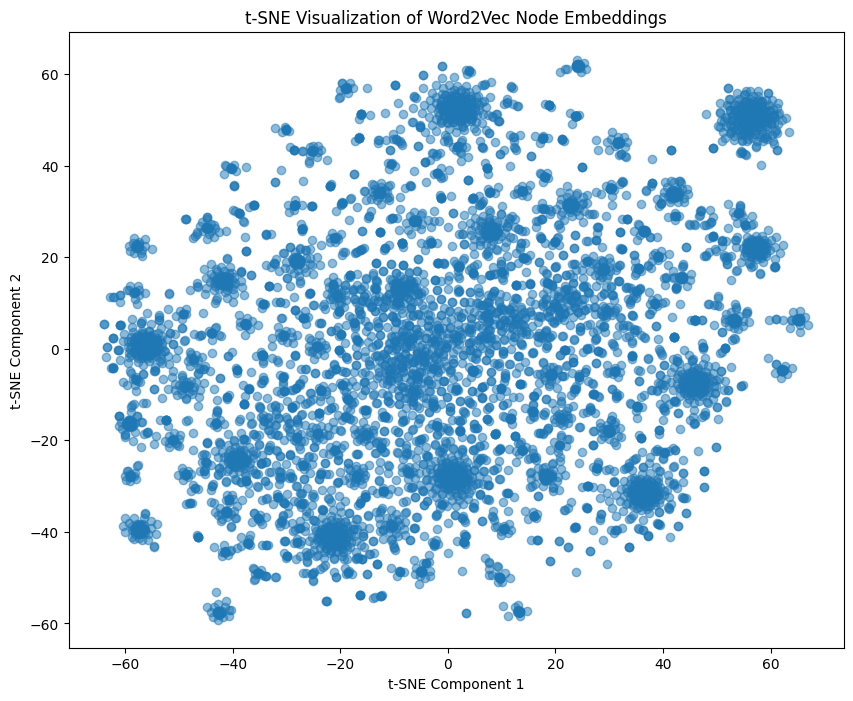

In [225]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming `node_embeddings` is a dictionary containing node IDs as keys and corresponding embeddings as values

# Extract node IDs and embeddings
node_ids = list(node_embeddings.keys())
embeddings = np.array([node_embeddings[node_id] for node_id in node_ids])

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)

plt.title('t-SNE Visualization of Word2Vec Node Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()
